# Smiles in-depth analysis      

I am still working on this as of 03/12/22. This Jupyter Notebook will either be updated or additional notebooks added. A few functions are written to get the tediousness out of the way.                                     

## 1. Load the libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi


## 2. Installing RDkit

RDkit is a Python package that contains a lot of great functions for visualizing small molecules and interpretting SMILES strings. You can even use RDkit to see if a SMILES string is valid. This function is really useful for training generative networks or reinforcement learning agents!

Check out  the [RDkit documentation](https://www.rdkit.org/docs/GettingStartedInPython.html)!

Use of molecular descriptor methods can be found [here](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html).

**Molecular descriptors available**

* Gasteiger/Marsili Partial Charges
* BalabanJ
* BertzCT
* Ipc
* HallKierAlpha
* Kappa1 - Kappa3
* Phi
* Chi0, Chi1
* Chi0n - Chi4n
* Chi0v - Chi4v
* MolLogP
* MolMR
* MolWt
* ExactMolWt
* HeavyAtomCount
* HeavyAtomMolWt
* NHOHCount
* NOCount
* NumHAcceptors
* NumHDonors
* NumHeteroatoms
* NumRotatableBonds
* NumValenceElectrons
* NumAmideBonds
* Num{Aromatic,Saturated,Aliphatic}Rings
* Num{Aromatic,Saturated,Aliphatic}{Hetero,Carbo}cycles
* RingCount
* FractionCSP3
* NumSpiroAtoms
* NumBridgeheadAtoms
* TPSA
* LabuteASA
* PEOE_VSA1 - PEOE_VSA14
* SMR_VSA1 - SMR_VSA10
* SlogP_VSA1 - SlogP_VSA12
* EState_VSA1 - EState_VSA11
* VSA_EState1 - VSA_EState10
* MQNs
* Topliss fragments
* Autocorr2D
* BCUT2D

**3D descriptors**

* Plane of best fit (PBF)
* PMI1, PMI2, PMI3
* NPR1, NPR2
* Radius of gyration
* Inertial shape factor
* Eccentricity
* Asphericity
* Spherocity Index
* Autocorr3D
* RDF
* MORSE
* WHIM
* GETAWAY

In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-02-25 15:10:07--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-02-25 15:10:08--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   153MB/s    in 0.6s    

2022-02-25 15:10:08 (153 MB/s) - ‘Minicon

## 3. Loading and preprocessing the dataset
While loading each SMILES string, I go ahead and tack on a '!' at the beginning and 'E' at the end. 'E's are added until the SMILES string len is equal to maxlen.
'!' and 'E' are acting as a starting and end token, respectively.

In [3]:
#Load the smiles strings. Add prefix character. Pad with suffix characters until the full character length.
smiles = open(dirname+'/'+filename)

smistr = []
#Set the maximum size SMILES string you want to gather.
maxlen = 50

for line in smiles:
  if len(line.split()[0]) <= maxlen:
    appendage = "!"
    appendage += line.split()[0]
    while len(appendage) <= maxlen:
      appendage += "E"
    smistr.append(appendage)
  else:
    continue
    
print ('Number of entries processed: ', len(smistr))

Number of entries processed:  991776


## 4. Creating a tokenzier and one-hot encoder of the SMILES strings

In [4]:
#Create a tokenizer for vectorization. 
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(smistr)
#text_to_sequences encoders
sequences = tokenizer.texts_to_sequences(smistr)
data = pad_sequences(sequences, maxlen=maxlen)
print ('Encoded string:',sequences[0])

Encoded string: [12, 3, 3, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
#sequences_to_text decodes
print ('Decoded string:',tokenizer.sequences_to_texts(data[0:1]))

Decoded string: ['C C O E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E']


In [6]:
def decoder(array, tokenizer):
    '''
    Converts one-hot encoded sequences into SMILES strings that are ready to view or recieve in RDkit.
    
    '''
    output = tokenizer.sequences_to_texts(array)
    #Modify this if you change the start or end token.
    disallowed_characters = 'E! '
    for character in disallowed_characters:
        output = [i.replace(character,'') for i in output]
    return output

In [7]:
decoded_smiles = decoder(data[490:502],tokenizer)
print (decoded_smiles)

['ON1CCCC1=O', 'CCC(C)(C)O', 'CCOC(=O)CC', 'CCCOC(C)=O', 'OCCNCCNCCO', 'CCCCCN(C)C', 'O=CNC1CCC1', 'O=C1CCC=C1', 'CCN(CC)CCN', 'CC(=O)NC#N', 'CN(C)CCCCN', 'NCCCCNCC=C']


## 5. Viewing decoded SMILES strings in RDkit

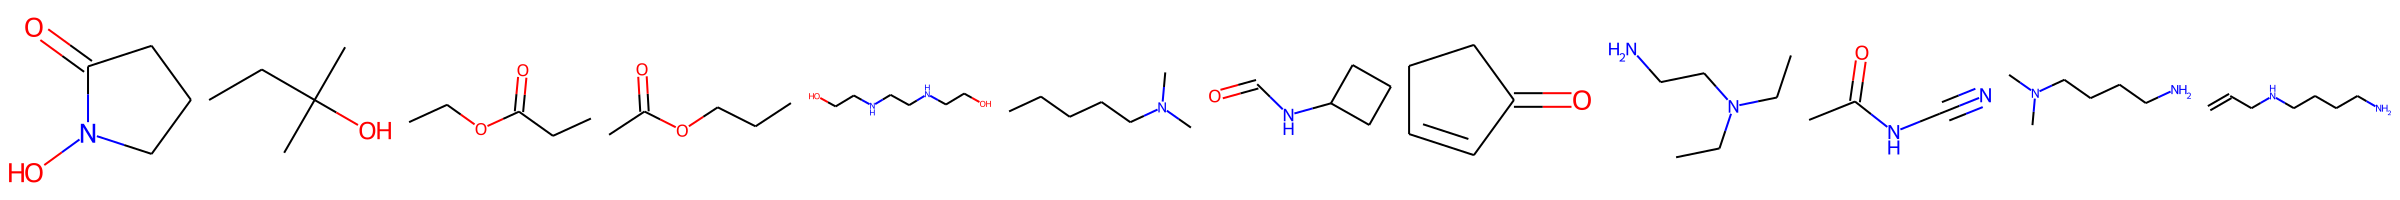

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, AllChem

#Convert each smiles string to an RDkit "mol" object and store in a list.
mols = [Chem.MolFromSmiles(i) for i in decoded_smiles]
#Use the MolsToImage method in Draw to view all the molecules.
Draw.MolsToImage(mols)


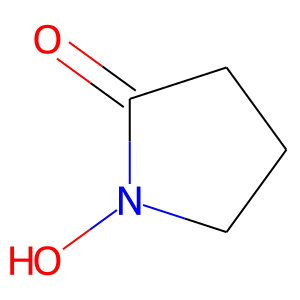

In [9]:
#Or use MolToImage in Draw and a single "mol" object (not in a list) to view that molecule..
Draw.MolToImage(mols[0])

## 6. Train/test splitting 

Further progress under development..

In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=42)